In [1]:
from profile_generation import load_image, realign_image, get_regionprops_3d, calculate_alpha_shape, filter_coordinates, smooth_coordinates, save_pts_list, generate_volume, imadjust
import numpy as np

# Load image and obtain profiles from 3D subvolumes

In [2]:
# Starting point from which to generate the volume from
start_point = (0, 300, 90)

# Total volume of the region of interest
total_vol = (998, 800, 1170)

# Binarization threshold value
threshold = 750

# Threshold to filter out small objects
small_object_size = 10

# umber of volumes to calculate the profile from
n_volume = 3

# Width of volume to calculate the profile from
width = 100

# Alpha value used in the determination of the alpha shape.
alpha = 0.02

# List of positional filters used to remove rogue objects that will affect the alpha shape
centroid_filters = ()

# Width from edge of image to remove coordinates from and only leave coordinates that define the surface curvature.
edge_width = 20

In [3]:
image = load_image([
    r"E://data//3DTFM//test_set//2021Nov02_3DTFM_3c_w1CSU RFP_t1.TIF",
    r"E://data//3DTFM//test_set//2021Nov02_3DTFM_3c_w1CSU RFP_t1-file002.TIF"
])

image = realign_image(image, z_reverse=False, z_start=2, y_start=1, x_start=1)
shape = image.shape

In [4]:
regionprops_3d = get_regionprops_3d(image, threshold, small_object_size=small_object_size)

pts_list = []
mid_pts = np.rint(np.linspace(start_point[1], start_point[1] + total_vol[1] - 1, n_volume, endpoint=True)).astype(np.int32)

for mid_pt in mid_pts:
    coords = calculate_alpha_shape(regionprops_3d, mid_pt, centroid_filters, width, alpha)
    filtered = filter_coordinates(coords, shape, edge_width)

    reslice_x, reslice_z = smooth_coordinates(filtered, start_point, total_vol)

    out_list = np.stack((reslice_z, reslice_x, np.repeat(mid_pt - start_point[1], len(reslice_x))))
    out_list = out_list.T
    pts_list.append(out_list)

save_pts_list(pts_list, suffix='')

vol = generate_volume(pts_list, total_vol)
np.savez(f"volume.npz", vol)

# Visualize generated profiles

In [6]:
import matplotlib.pyplot as plt

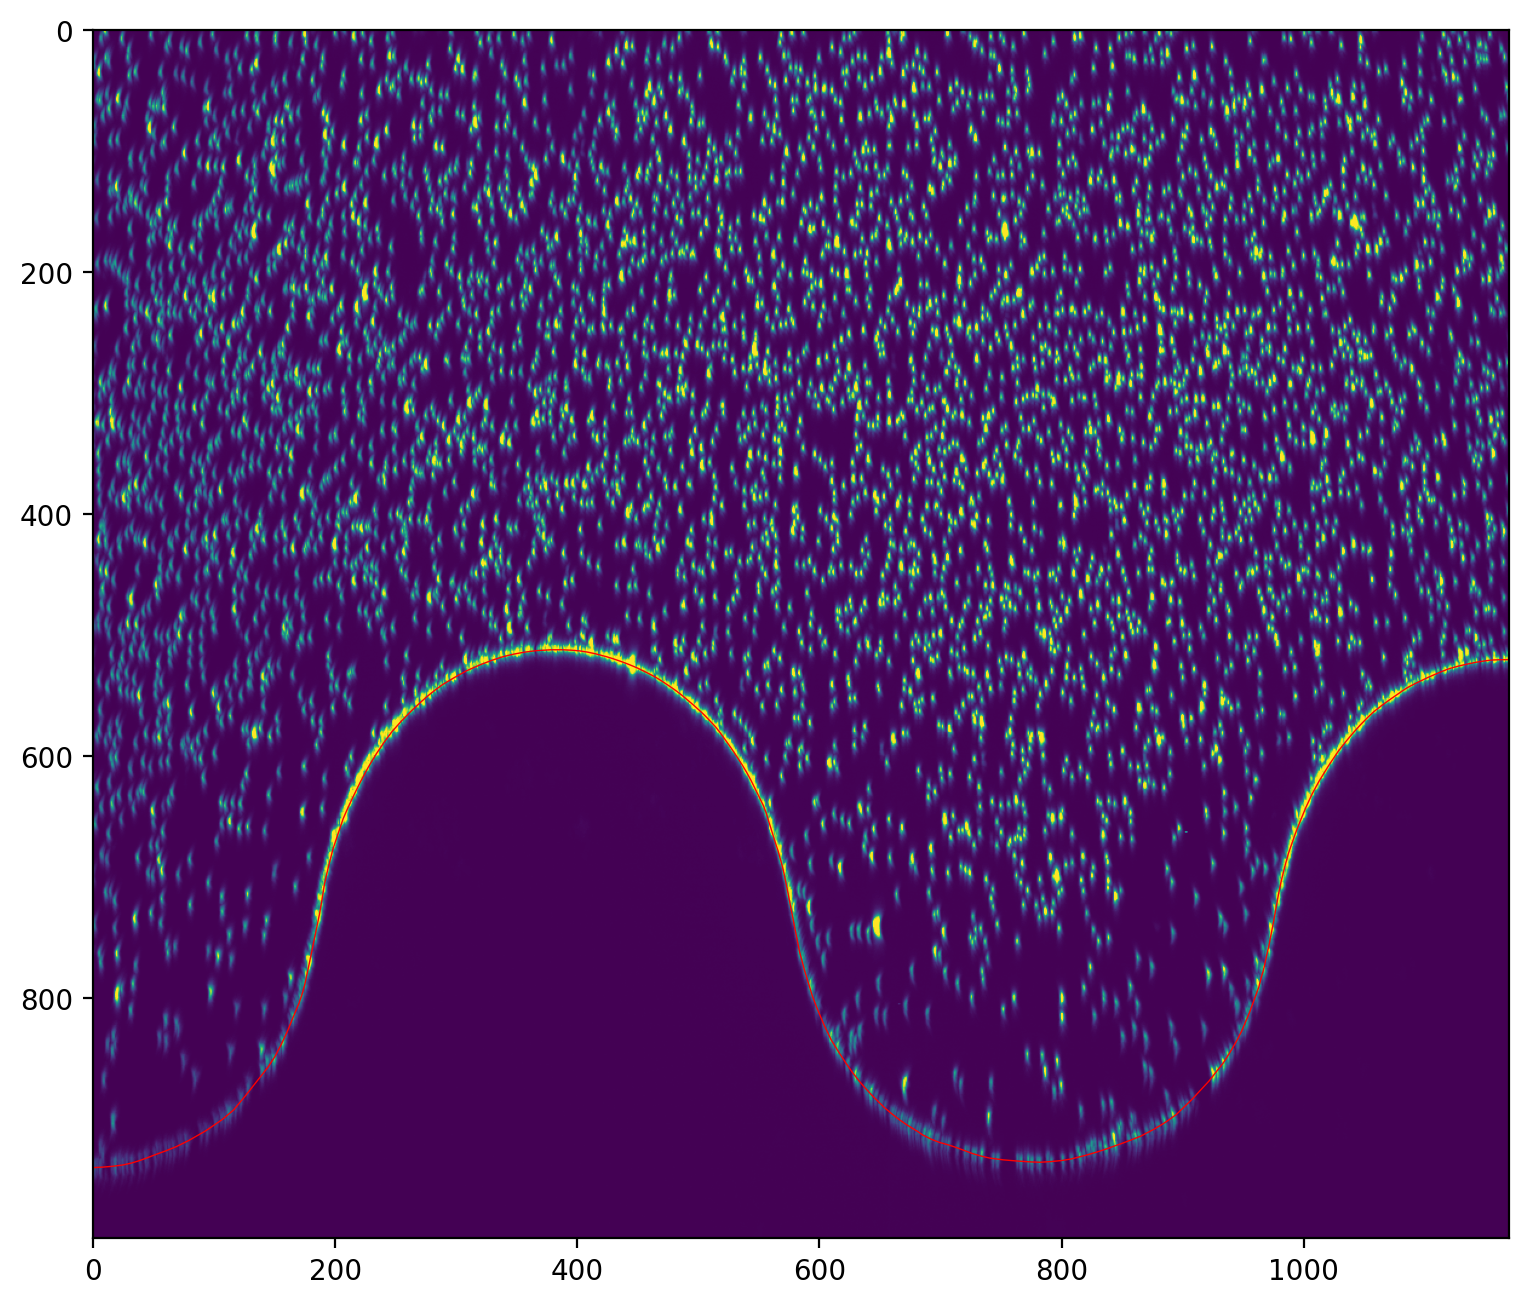

In [7]:
index = 0

start = mid_pts[index] - width
end = mid_pts[index] + width
max_image = np.max(image[:,start:end,:], axis=1)

plt.figure(figsize=(20,8), dpi=200)
plt.plot(pts_list[0][:,1], pts_list[0][:,0], 'r', linewidth=0.5)
plt.imshow(imadjust(max_image[::-1, start_point[2]:start_point[2]+total_vol[2]], [0.01,0.99]))